# Training PyTorch Model and Deploying it by Azure Machine Learning Services
## Train PyTorch model with resized images

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.image as mpimg
import requests

DATA_PATH = 'resized_images/'

In [2]:
def load_dataset(data_path):
    # Convert to Tensor and normalize
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load all of the images, transforming them
    full_dataset = datasets.ImageFolder(root=data_path, transform=data_transform)
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    
    # define a loader for the training/validation data we can iterate through in 16-image batches
    dataloaders = {}; dataset_sizes = {}
    dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
    dataloaders['val'] = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=8)
    
    dataset_sizes['train'] = train_size
    dataset_sizes['val'] = val_size
    
    class_names = full_dataset.classes
    print(class_names)
    
    return dataloaders, dataset_sizes, class_names

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # images are 3 (RGB) x 128 x 128
        self.conv1 = nn.Conv2d(3, 6, 5)  # 128-5+1=124
        self.pool1 = nn.MaxPool2d(2, 2) # 124/2=62
        self.conv2 = nn.Conv2d(6, 16, 5) # 62-5+1=58
        self.pool2 = nn.MaxPool2d(2, 2) # 58/2=29
        self.fc1 = nn.Linear(16*29*29, 12)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*29*29)
        x = self.fc1(x)
        return x

In [4]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, class_names, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            losses[phase].append(epoch_loss)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
dataloaders, dataset_sizes, class_names = load_dataset(DATA_PATH)

# if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = {'train':[], 'val':[]}
num_epochs=10

train_model(net, criterion, optimizer, dataloaders, dataset_sizes, class_names, num_epochs=num_epochs)

['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']
Epoch 0/9
----------
train Loss: 1.2996 Acc: 0.5731
val Loss: 0.7558 Acc: 0.7661

Epoch 1/9
----------
train Loss: 0.6370 Acc: 0.8013
val Loss: 0.4905 Acc: 0.8399

Epoch 2/9
----------
train Loss: 0.4457 Acc: 0.8471
val Loss: 0.4846 Acc: 0.8446

Epoch 3/9
----------
train Loss: 0.3469 Acc: 0.8815
val Loss: 0.4119 Acc: 0.8744

Epoch 4/9
----------
train Loss: 0.2641 Acc: 0.9091
val Loss: 0.4025 Acc: 0.8603

Epoch 5/9
----------
train Loss: 0.1964 Acc: 0.9293
val Loss: 0.4191 Acc: 0.8681

Epoch 6/9
----------
train Loss: 0.1563 Acc: 0.9461
val Loss: 0.3238 Acc: 0.8948

Epoch 7/9
----------
train Loss: 0.1342 Acc: 0.9603
val Loss: 0.4283 Acc: 0.8807

Epoch 8/9
----------
train Loss: 0.1324 Acc: 0.9535
val Loss: 0.3871 Acc: 0.8838

Epoch 9/9
----------
train Loss: 0.0990 Acc: 0.9630
val Loss: 0.4500 Acc: 0.8823

Training complete in 0m 23s
Best

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13456, out_features=12, bias=True)
)

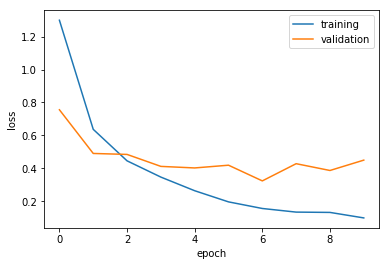

In [6]:
plt.plot(range(num_epochs), losses['train'])
plt.plot(range(num_epochs), losses['val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [7]:
net.eval()
y_val = []
y_pred = []
# Iterate over validatation set for calculating confusion matrix
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    preds = torch.argmax(outputs, dim=1)
    y_pred = itertools.chain(y_pred, preds.cpu().numpy().tolist())
    y_val = itertools.chain(y_val, labels.cpu().numpy().tolist())

print("\n Confusion Matrix:")
cm = confusion_matrix(list(y_val), list(y_pred))
print(cm)


 Confusion Matrix:
[[ 16   0   0   0   0   0   0   0   0   0   0   0]
 [  0  39   0   0   1   0   0   0   0   0   0   0]
 [  4   0  70   1   1   0   0   0   0   1   0   0]
 [  0   0   2  31   0   0   0   0   0   1   0   0]
 [  0   0   1   0  63   1   0   0   1   0   0   0]
 [  1   0   0   0   1 120   0   0  16   0   1   0]
 [  1   0   0   1   0   0  59   0   0   0   1   0]
 [  0   0   0   0   0   0   0  26   0   0   1   0]
 [  0   0   0   0   0  24   0   0  45   0   1   0]
 [  0   0   0   0   0   0   0   0   0  12   0   0]
 [  1   0   0   0   1   0   0   0   0   0  52   0]
 [  0   1   0   0   0   0   0   1   0   0   1  37]]


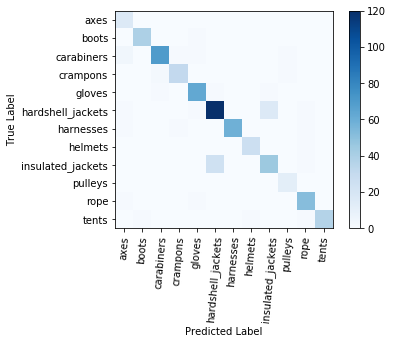

In [8]:
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=85)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [9]:
# Save the model
MODEL_PATH = 'adventureworks.pth'
torch.save(net.state_dict(), MODEL_PATH)
print("Model saved.")

Model saved.


In [10]:
# function to resize new images to match training data
def resize_image(img, size=(128,128)):    
    # Create a white image of the target size
    newimg = Image.new("RGB", size, (255, 255, 255))
        
    # resize the source image (if not square, this will scale largest dimension to size)
    img.thumbnail(size, Image.ANTIALIAS)
    
    # paste the resized source image into the middle of the target image
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg

In [11]:
# Function to predict
def predict_image(classifier, image, device):
    with torch.no_grad():
        classifier.eval()
        classifier.to(device)

        # Apply the same transformations as we did for the training images
        transformation = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Preprocess the image
        image_tensor = transformation(image)
        image_tensor = image_tensor.to(device)
        # Add an extra batch dimension since pytorch treats all images as batches
        image_tensor = image_tensor.unsqueeze(0)

        # Predict the class of the image
        outputs = classifier(image_tensor)
        preds = torch.argmax(outputs, dim=1)
        index = preds
        return index

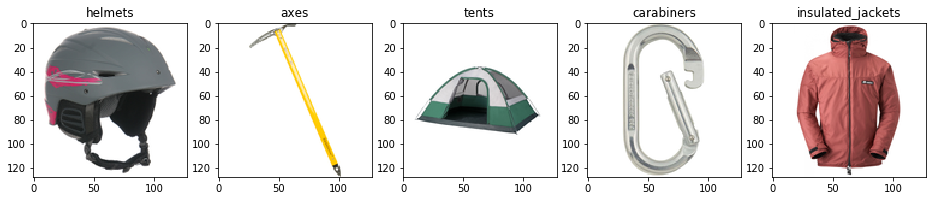

In [12]:
# Predict class for new data
image_urls = []
image_urls.append('http://images.the-house.com/giro-g10mx-mtgy-07.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (128,128)

fig = plt.figure(figsize=(16, 12))

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

model = Net()
model.load_state_dict(torch.load(MODEL_PATH))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    img = resize_image(img, size)
    index = predict_image(model, img, device)
    class_name = class_names[index]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)

## Deploy trained PyTorch model with Azure Machine Learning Services

In [13]:
# Replace YOUR_SUBSCRIPTION_KEY in the following variable assignment:
SUBSCRIPTION_ID = 'YOUR_SUBSCRIPTION_KEY'

In [14]:
# Check installed Azure ML version

import azureml.core
print(azureml.core.VERSION)

1.0.2


In [15]:
# Create an Azure ML workspace
from azureml.core import Workspace
ws = Workspace.create(name='adventureworks-ml',
                      subscription_id=SUBSCRIPTION_ID,
                      resource_group='openhack',
                      create_resource_group=True,
                      location='eastus2' # or other supported Azure region
                     )

*The above cell will result in output similar to the following. Click the link and enter the code to authenticate.*

```
Performing interactive authentication. Please follow the instructions on the terminal.

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ***A_CODE*** to authenticate.

Interactive authentication successfully completed.

UserWarning: The resource group doesn't exist or was not provided. AzureML SDK is creating a resource group=openhack in location=eastus2 using subscription=***YOUR_SUBSCRIPTION_ID***.
```

In [16]:
# Save the workspace config so we can load it again in later sessions
ws.write_config()

Wrote the config file config.json to: /data/home/graeme/notebooks/openhack/aml_config/config.json


In [17]:
# Test loading it
from azureml.core import Workspace
ws = Workspace.from_config()

Found the config file in: /data/home/graeme/notebooks/openhack/aml_config/config.json


In [18]:
%%writefile score.py

# create a scoring script that loads and infers from the model
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from azureml.core.model import Model
from PIL import Image
from io import BytesIO
import base64

def init():
    global model
    global device
    MODEL_NAME = 'adventureworks.pth'
    # retreive the local path to the model using the model name
    MODEL_PATH = Model.get_model_path(MODEL_NAME)
    # if GPU available, use cuda
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = Net()
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# REST API served by Azure ML only supports json input now
def run(json_data):
    try:
        encoded_img = json.loads(json_data)['image']
        decoded_img = base64.b64decode(encoded_img)
        image = Image.open(BytesIO(decoded_img))
        # make prediction
        preds = predict_image(model, image, device)
        return json.dumps(preds.tolist())
    except Exception as e:
        result = str(e)
        # return error message back to the client
        return json.dumps({"error": result})

# Function to predict
def predict_image(classifier, image, device):
    with torch.no_grad():
        classifier.eval()
        classifier.to(device)

        # Apply the same transformations as we did for the training images
        transformation = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Preprocess the image
        image_tensor = transformation(image)
        image_tensor = image_tensor.to(device)
        # Add an extra batch dimension to single image since pytorch treats all images as batches
        image_tensor = image_tensor.unsqueeze(0)

        # Predict the class of the image
        outputs = classifier(image_tensor)
        return outputs
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # images are 3 (RGB) x 128 x 128
        self.conv1 = nn.Conv2d(3, 6, 5)  # 128-5+1=124
        self.pool1 = nn.MaxPool2d(2, 2) # 124/2=62
        self.conv2 = nn.Conv2d(6, 16, 5) # 62-5+1=58
        self.pool2 = nn.MaxPool2d(2, 2) # 58/2=29
        self.fc1 = nn.Linear(16*29*29, 12)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*29*29)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

Overwriting score.py


In [19]:
from azureml.core.conda_dependencies import CondaDependencies 

# Create a .yml config file to install dependencies in the container
myenv = CondaDependencies()
myenv.add_conda_package("pytorch=0.4.1")
myenv.add_conda_package("numpy")
myenv.add_conda_package("pillow")
myenv.add_channel("pytorch")
myenv.add_pip_package("torchvision")

with open("pytorch-aml.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
print("Conda Dependencies file created.")

with open("pytorch-aml.yml","r") as f:
    print(f.read())

Conda Dependencies file created.
# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
  - torchvision
- pytorch=0.4.1
- numpy
- pillow
channels:
- pytorch



In [20]:
from azureml.core.image import ContainerImage

# Define a container image that uses the score and dependencies files
image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "pytorch-aml.yml",
                                                  description = "Adventure Works scikit-learn classifier",
                                                  tags = {"data": "Adventure Works gear", "type": "classification"}
                                                 )
print("Container image defined.")

Container image defined.


In [21]:
from azureml.core.webservice import AciWebservice

# Define the service configuration
aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {"data": "Adventure Works gear", "type": "classification"},
                                               description = 'Adventure Works scikit-learn classifier')

print("Service config defined.")

Service config defined.


In [22]:
from azureml.core.webservice import Webservice

# Deploy the container as a service named aw-sk-svc, registering the locally saved model
service_name = 'aw-sk-svc'
print('start creating image')
since = time.time()
service = Webservice.deploy(deployment_config = aciconfig,
                                image_config = image_config,
                                model_paths = ['adventureworks.pth'],
                                name = service_name,
                                workspace = ws)

service.wait_for_deployment(show_output = True)
print(service.state)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

start creating image
Registering model adventureworks.pth
Creating image
Image creation operation finished for image aw-sk-svc:1, operation "Succeeded"
Creating service
Running............................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy
Training complete in 8m 28s


## Call the deployed API

gloves


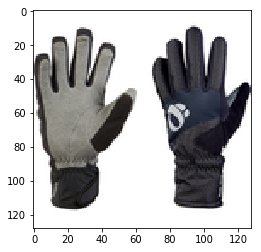

In [25]:
import json
from random import randint
from PIL import Image, ImageOps
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import base64

class_names = ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']

# Create a test image
img_url = "https://www.wigglestatic.com/images/pearl-8818-med.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

#pre-process the image so it matches the training set
img = resize_image(img, (128,128))
buffered = BytesIO()
img.save(buffered, format="JPEG")

# this returns binary
encoded_string = base64.b64encode(buffered.getvalue())

req_file = encoded_string.decode('utf-8')
test_sample = json.dumps({"image": req_file})

# Call the service to get the predicted class
prediction = service.run(input_data = test_sample)
class_id = np.argmax(json.loads(prediction)[0])

# Print the results (and the image)
print(class_names[class_id])
plt.imshow(img)

In [26]:
print(service.get_logs())

2019-01-15T21:47:15,450288247+00:00 - rsyslog/run 
2019-01-15T21:47:15,450641562+00:00 - gunicorn/run 
2019-01-15T21:47:15,450137941+00:00 - iot-server/run 
2019-01-15T21:47:15,450827869+00:00 - nginx/run 
ok: run: rsyslog: (pid 14) 1s
ok: run: gunicorn: (pid 13) 1s
ok: run: nginx: (pid 11) 1s
ok: run: rsyslog: (pid 14) 1s
ok: run: rsyslog: (pid 14) 1s
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-01-15T21:47:15,733972603+00:00 - iot-server/finish 1 0
2019-01-15T21:47:15,735022646+00:00 - Exit code 1 is normal. Not restarting iot-server.
{"timestamp": "2019-01-15T21:47:16.364179Z", "message": "Starting gunicorn 19.6.0", "host": "wk-caas-66dacd487c614352873c127e2ba72d4e-858bb5cdd6ff82346dd9b0", "path": "/opt/miniconda/lib/python3.6/site-packages/gunicorn/glogging.py", "tags": "%(module)s, %(asctime)s, %(levelname)s, %(message)s", "level": "INFO", "logger": "gunicorn.error", "msg": "Starting gunicorn %s", "stack_info": null}
{"timestamp": "2019-01-15T21:

In [27]:
# Delete the service when finished with it
service.delete()